# Libraries import #
***
---

In [1]:
#manipulation of data
import pandas as pd     
import numpy as np


#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('bmh')
plt.style.use('ggplot')

#modeling
from sklearn.tree import plot_tree
import plotly.express as px
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

#evaluation metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller


# No presentar advertencias
import warnings
warnings.filterwarnings("ignore")
from DateTime import DateTime



# Extract the Dataset | Only working with "XOM" Exxon Mobil #
***
---

In [2]:
df= pd.read_csv("/Users/me/Desktop/ML_ExxonMobile_Forecast/src/data/oil and gas stock prices.csv")
df = df.loc[df.Symbol=="XOM"]
df.head()
df.index = pd.to_datetime(df.Date)
df = df[["Close"]].copy()
df.rename(columns={"Close":"Value"},inplace=True)
df.head()

,Value
Date,
2000-01-03,39.16
2000-01-04,38.41
2000-01-05,40.50
2000-01-06,42.59
2000-01-07,42.47


# Setting the Frequency of the TimeStamp to Daily #
***
---

In [4]:
freq = pd.infer_freq(df.index)

df.index.freq = freq

ts_resampled =df.asfreq('D')

print(ts_resampled)

             Value
Date              
2000-01-03   39.16
2000-01-04   38.41
2000-01-05   40.50
2000-01-06   42.59
2000-01-07   42.47
...            ...
2022-06-06   98.84
2022-06-07  103.37
2022-06-08  104.59
2022-06-09  102.33
2022-06-10  100.46

[8195 rows x 1 columns]


In [5]:
ts_resampled.head(10)#dataframe with the extended dates

,Value
Date,
2000-01-03,39.16
2000-01-04,38.41
2000-01-05,40.50
2000-01-06,42.59
2000-01-07,42.47
2000-01-08,NaN
2000-01-09,NaN
2000-01-10,41.88
2000-01-11,42.00


# Frequency rectification of the Dataframe #
***
---

In [6]:
freq = pd.infer_freq(ts_resampled.index)

print(freq)

D


# Interpolation of Values with "fillna"
***
---

In [7]:
df = ts_resampled.fillna(method='ffill')


# Double Checking the frequency after the new values #
***
---

In [8]:
freq = pd.infer_freq(df.index)

print(freq)

D


# New Values #
***
---

In [9]:
df.head(10)

,Value
Date,
2000-01-03,39.16
2000-01-04,38.41
2000-01-05,40.50
2000-01-06,42.59
2000-01-07,42.47
2000-01-08,42.47
2000-01-09,42.47
2000-01-10,41.88
2000-01-11,42.00


# Feature engineering for Data exploration #
***
---

In [10]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['weekofyear'] = df.index.isocalendar().week
    df['year'] = df.index.year
    return df

df = create_features(df)


In [11]:
df.head()

,Value,quarter,month,weekofyear,year
Date,,,,,
2000-01-03,39.16,1,1,1,2000
2000-01-04,38.41,1,1,1,2000
2000-01-05,40.50,1,1,1,2000
2000-01-06,42.59,1,1,1,2000
2000-01-07,42.47,1,1,1,2000


### Saving the Dataframe with the new features for Data visualization ###
***
---

In [12]:
df.to_csv('withfeatures.csv')

### Target relationship visualization ###
##### Value of the stock in their "Close" stage per year #####
***
---

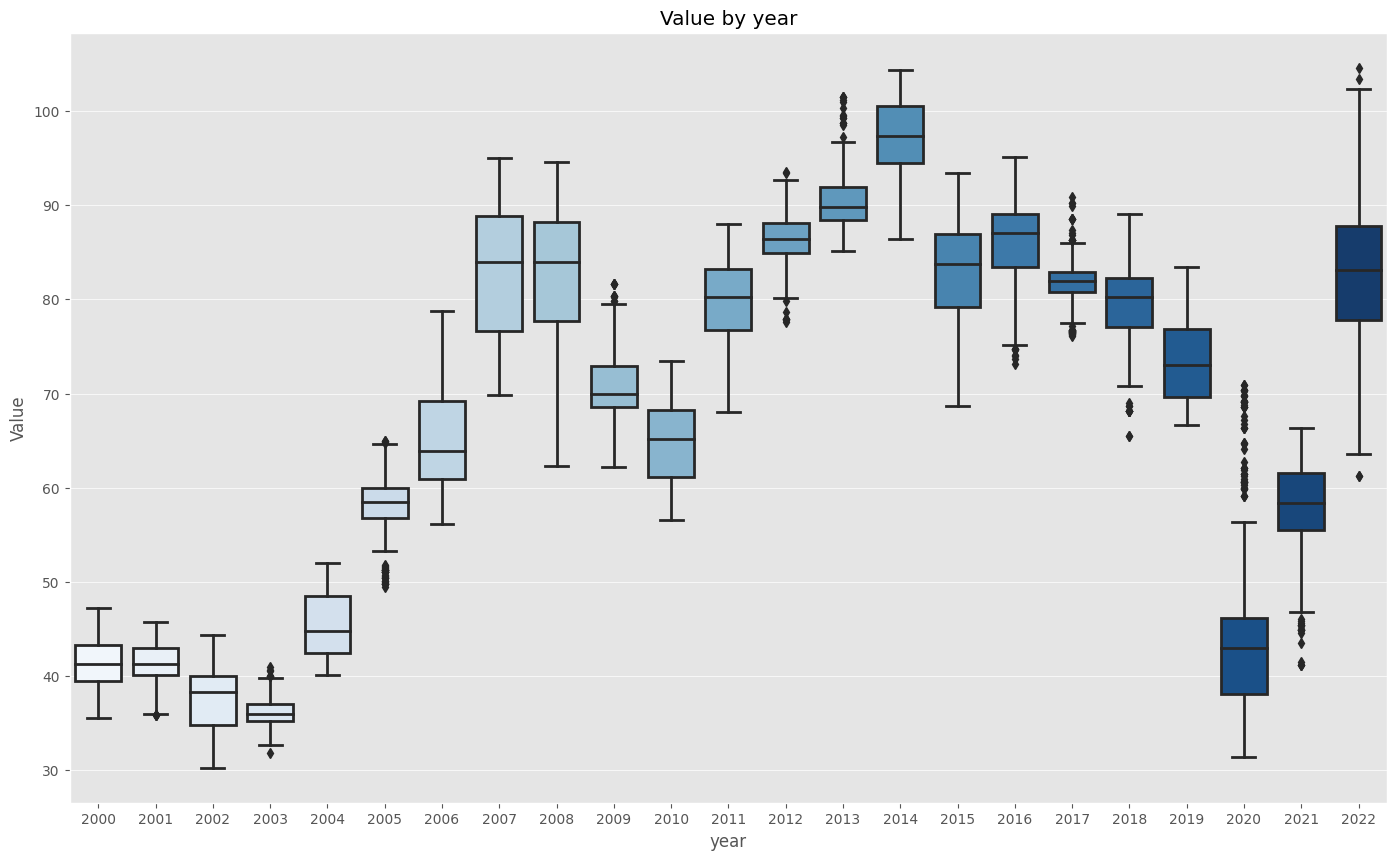

In [13]:
fig, ax = plt.subplots(figsize=(17, 10))
sns.boxplot(data=df, x="year", y='Value', palette='Blues')
ax.set_title('Value by year')
plt.show()

In [14]:
df= df[["Value"]].copy()
df.head()

,Value
Date,
2000-01-03,39.16
2000-01-04,38.41
2000-01-05,40.50
2000-01-06,42.59
2000-01-07,42.47


# Vizualizationof Data on 2000-2022 period #
***
---

In [15]:
fig= px.line(df, x=df.index, y="Value", title="Exxon Mobile")
fig.show()

# Outliers detection #
##### We have Several outliers from 2000-2005 and 2021 #####
##### The first round are far from the "Regular price" but at the same time we had a downfall due COVID-19 #####
##### We kept the outliers to learn from that kind of irregular pattern #####


***
---

<Axes: ylabel='Frequency'>

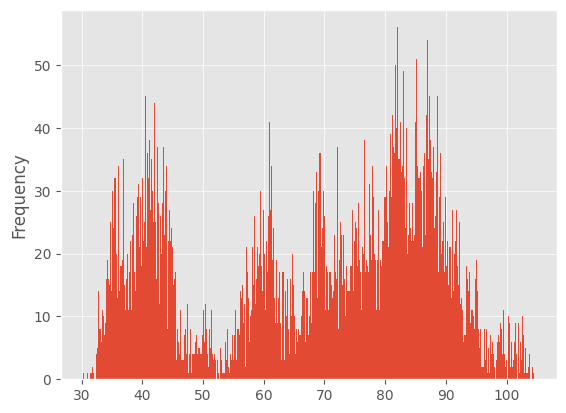

In [16]:
df["Value"].plot(kind='hist', bins=500)


### The identification of "Outliers" were prices in the Close of the day from 2000 to 20022 ###
### The outliers were the closing values under 40 USD #
***
---


<Axes: title={'center': 'Outliers'}, xlabel='Date'>

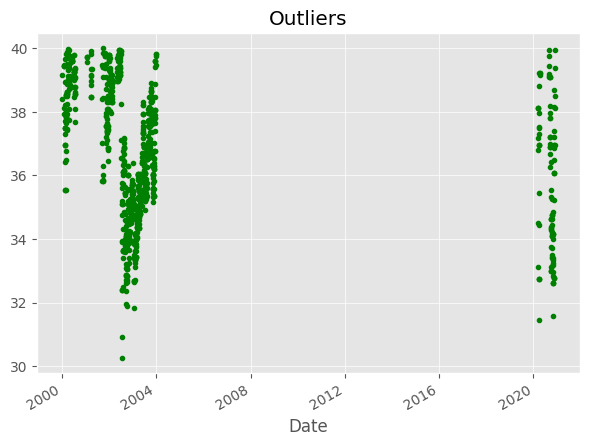

In [17]:
df.query("Value < 40")["Value"] \
    .plot(style='.',
          figsize=(7, 5),
          color="green",
          title='Outliers')

# Density distribution plotting #
***
---

,Value
count,8195.000000
mean,67.955834
std,19.417915
min,30.270000
25%,48.260000
50%,72.130000
75%,84.025000
max,104.590000


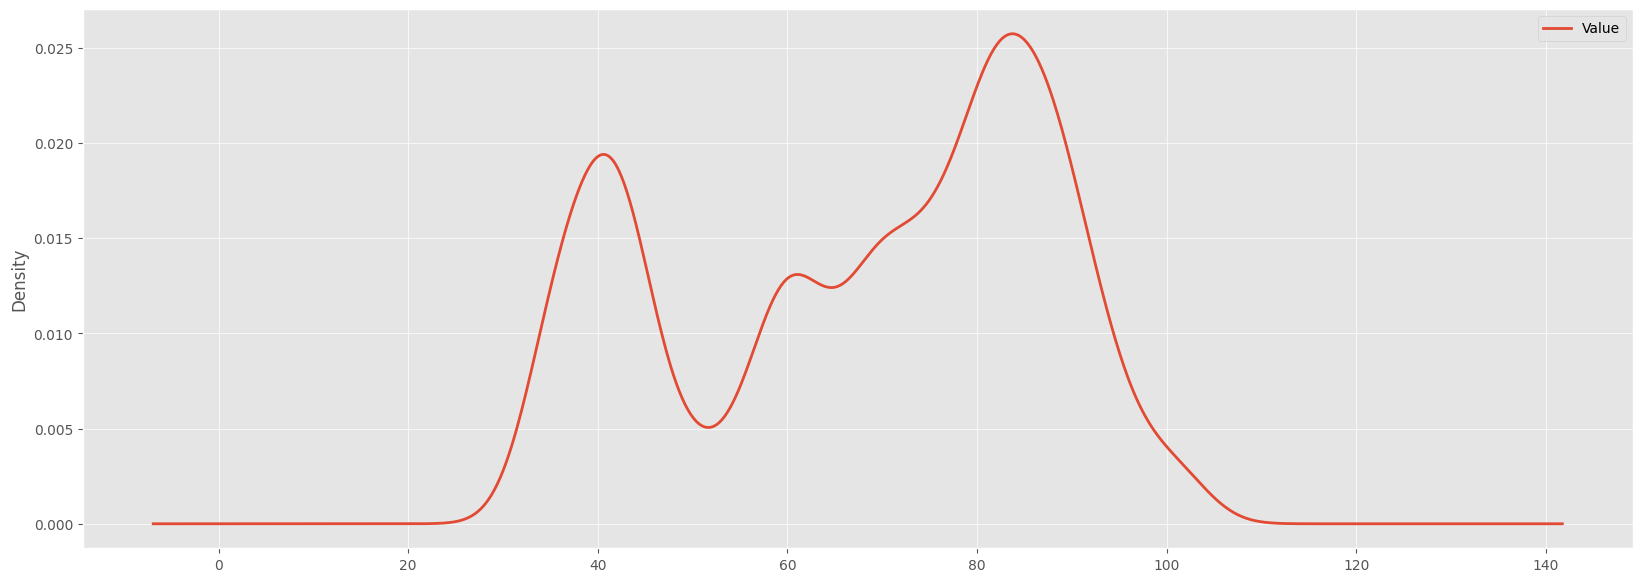

In [18]:
df.plot(kind="kde",figsize=(20,7))
df.describe()

# Dickey-Fuller test function #
***
---

In [19]:
def Prueba_Dickey_Fuller(series):
    
    print (f"Resultados de la prueba de Dickey-Fuller")
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        StopIteration

### Dickey-Fuller test ###
***
---

In [20]:
Prueba_Dickey_Fuller(df["Value"])

Resultados de la prueba de Dickey-Fuller
Test Statistic                          -1.575803
p-value                                  0.495736
No Lags Used                             9.000000
Número de observaciones utilizadas    8185.000000
Critical Value (1%)                     -3.431149
Critical Value (5%)                     -2.861893
Critical Value (10%)                    -2.566958
dtype: float64


## Lag creation ##
***
---

In [21]:
for i in range(4,0,-1):
    df["t-"+str(i)] = df["Value"].shift(i)

In [22]:
df.dropna(inplace=True)
df.head(15)

,Value,t-4,t-3,t-2,t-1
Date,,,,,
2000-01-07,42.47,39.16,38.41,40.50,42.59
2000-01-08,42.47,38.41,40.50,42.59,42.47
2000-01-09,42.47,40.50,42.59,42.47,42.47
2000-01-10,41.88,42.59,42.47,42.47,42.47
2000-01-11,42.00,42.47,42.47,42.47,41.88
2000-01-12,41.75,42.47,42.47,41.88,42.00
2000-01-13,42.72,42.47,41.88,42.00,41.75
2000-01-14,41.88,41.88,42.00,41.75,42.72
2000-01-15,41.88,42.00,41.75,42.72,41.88


## Train & Test ##
The implementation of the X,y to provide values to the Model.
***
---

In [23]:
X = df.iloc[:,1:].values
y = df.iloc[:,0].values
X_train = X[:6500]
X_test = X[6500:]
y_train = y[:6500]
y_test = y[6500:]

print("Shape X_train:", X_train.shape)
print("Shape X_test", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test:", y_test.shape)


Shape X_train: (6500, 4)
Shape X_test (1691, 4)
Shape y_train: (6500,)
Shape y_test: (1691,)


In [24]:
df.iloc[6500:]

,Value,t-4,t-3,t-2,t-1
Date,,,,,
2017-10-24,83.47,83.11,83.11,83.11,83.24
2017-10-25,83.17,83.11,83.11,83.24,83.47
2017-10-26,83.47,83.11,83.24,83.47,83.17
2017-10-27,83.71,83.24,83.47,83.17,83.47
2017-10-28,83.71,83.47,83.17,83.47,83.71
...,...,...,...,...,...
2022-06-06,98.84,97.67,99.09,99.09,99.09
2022-06-07,103.37,99.09,99.09,99.09,98.84
2022-06-08,104.59,99.09,99.09,98.84,103.37


## Data Vizualization ##
***
---

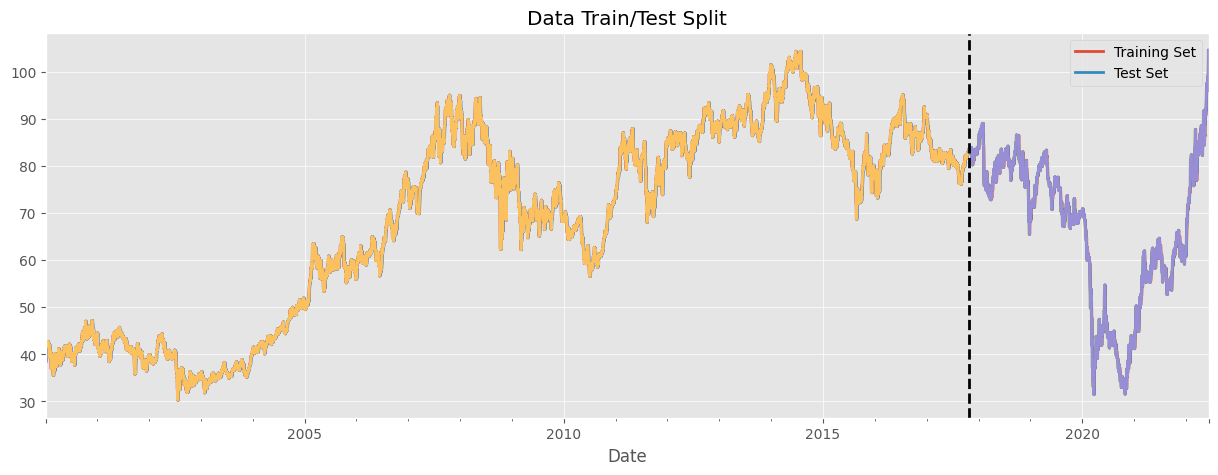

In [25]:
train = df.loc[df.index < '2017-10-24']
test = df.loc[df.index >= '2017-10-24']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2017-10-24', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### Implementation of a Decission Tree Regressor ###
***
---

In [26]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()

tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [27]:
def prediction(model, x_test):
    preds = x_test[0]
    preds_out = []
    
    for i in range(len(X_test)):
        pred = model.predict([preds])[0]
        preds_out.append(pred)
        
        preds2 = np.array([preds[1:]]) 
        
        preds = np.c_[preds2, np.array([pred])][0]
        
    return preds_out

In [28]:
preds = prediction(tree, X_test)


### Visualization of the prediction ###
y_test values were in the downfall of the prices of 2021 due the COVID-19
Stock prices are volatily and subjected to several factors like OPEC regulations and social impact 
***
---

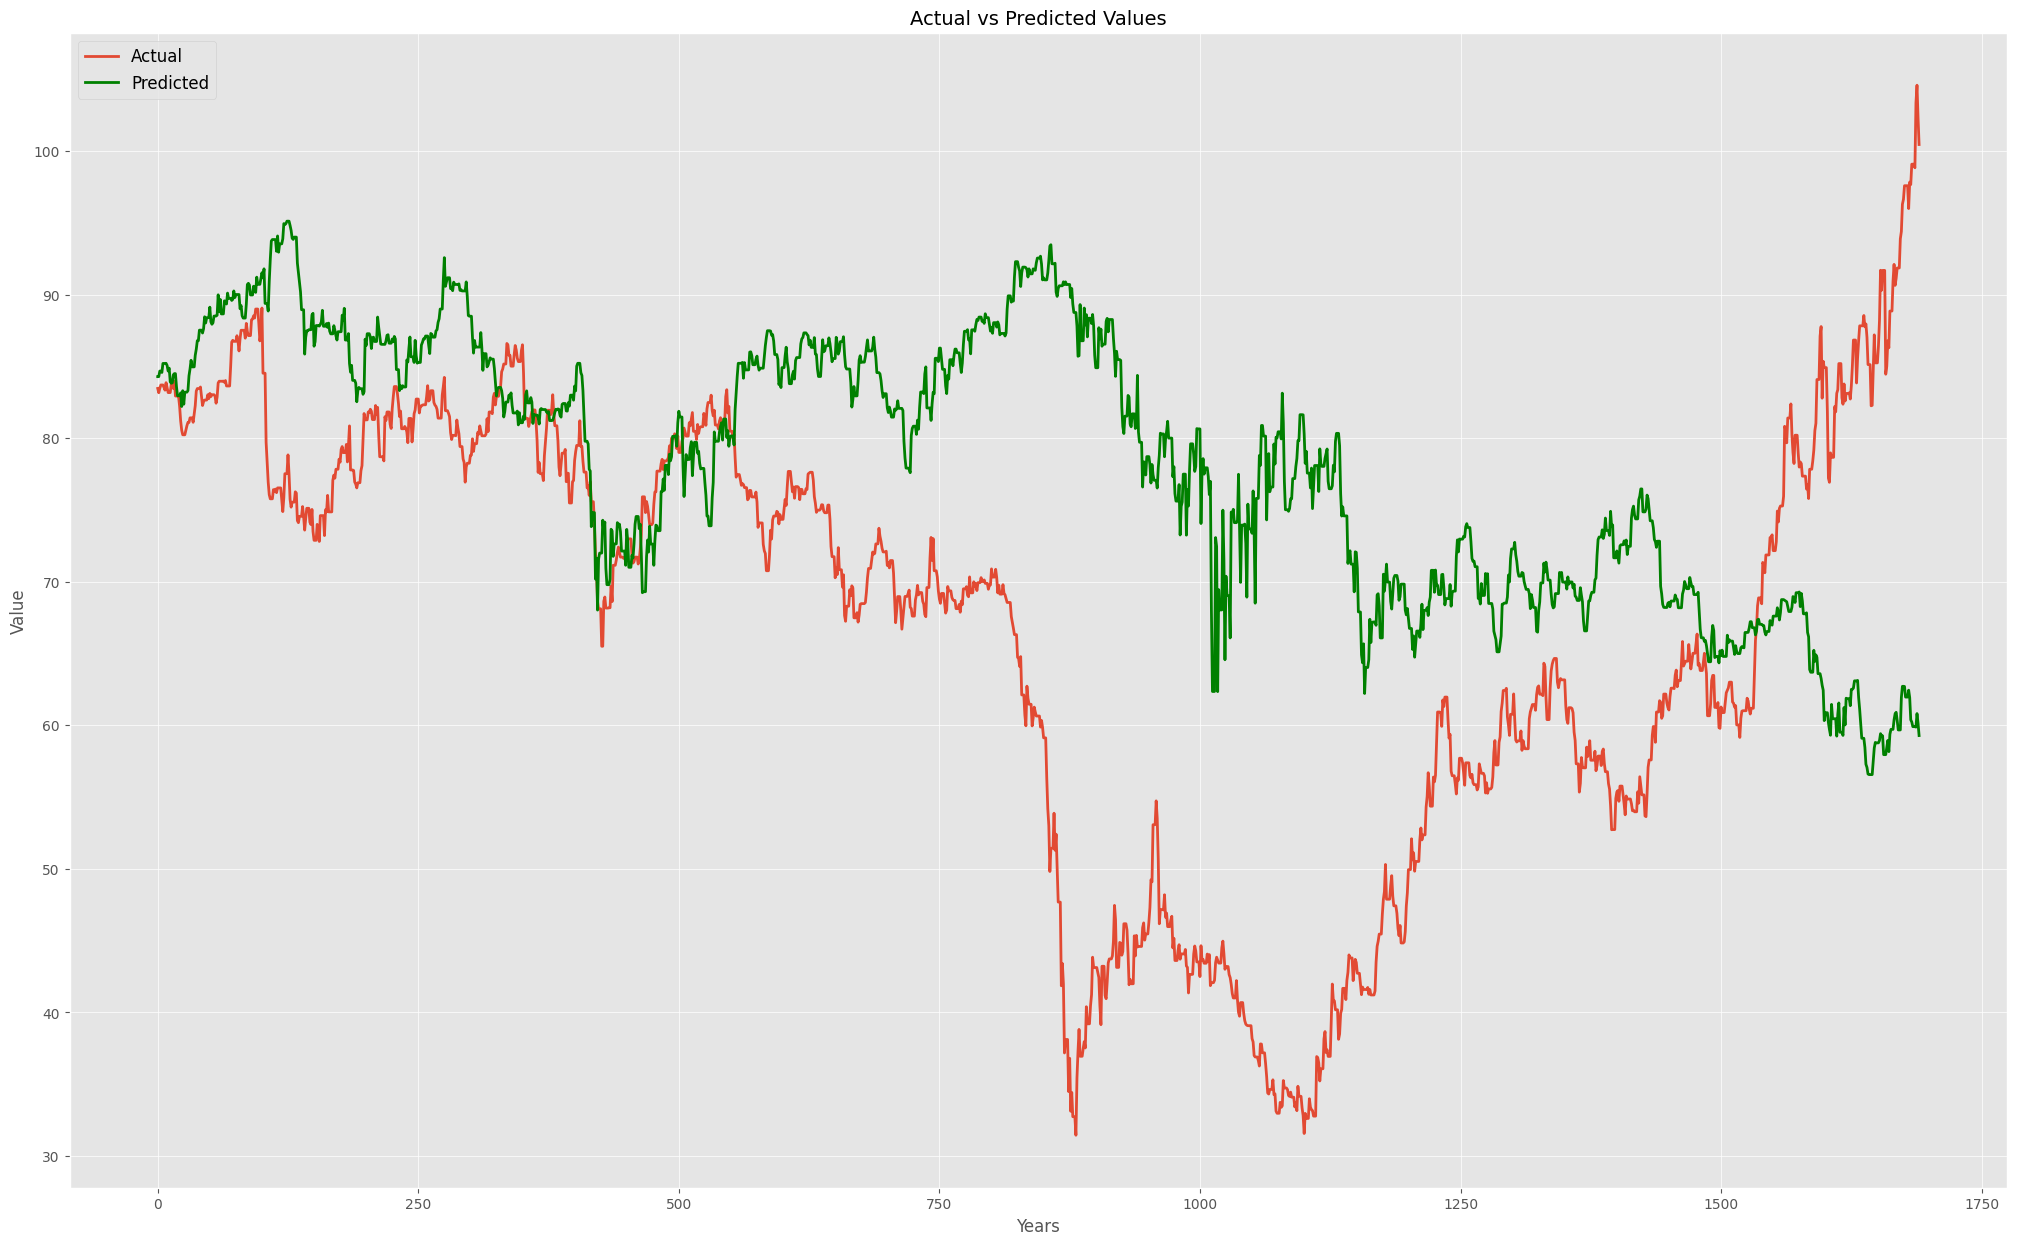

In [29]:
plt.figure(figsize=(25, 15))
plt.plot(y_test, '-', label='Actual')
plt.plot(preds, '-', color='green', label='Predicted')
plt.xlabel('Years', fontsize=12)
plt.ylabel('Value', fontsize=12)

plt.title('Actual vs Predicted Values', fontsize=14)
plt.legend(fontsize=12)
plt.show()

### Mean squared error ###
***
---

In [30]:
print("MSE:", mean_squared_error(preds, y_test))



MSE: 426.7865256505027


## XGBoost regressor & Grid Search cross Validation ##
***
---

In [31]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.5],
}

# Create an instance of the XGBRegressor model
xgb = XGBRegressor(random_state=42)

# Create a GridSearchCV object and fit it to the data
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)


Best parameters:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
Best score:  1.1283231439270356


### Modeling the XGBoost model ###
***
---

In [32]:
model = XGBRegressor(n_estimators=200, max_depth=2, learning_rate=0.01)


In [33]:
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [34]:
predictions = model.predict(X_test)


In [35]:
mse = mean_squared_error(y_test, predictions)
print('MSE:', mse)

MSE: 80.55969914387451


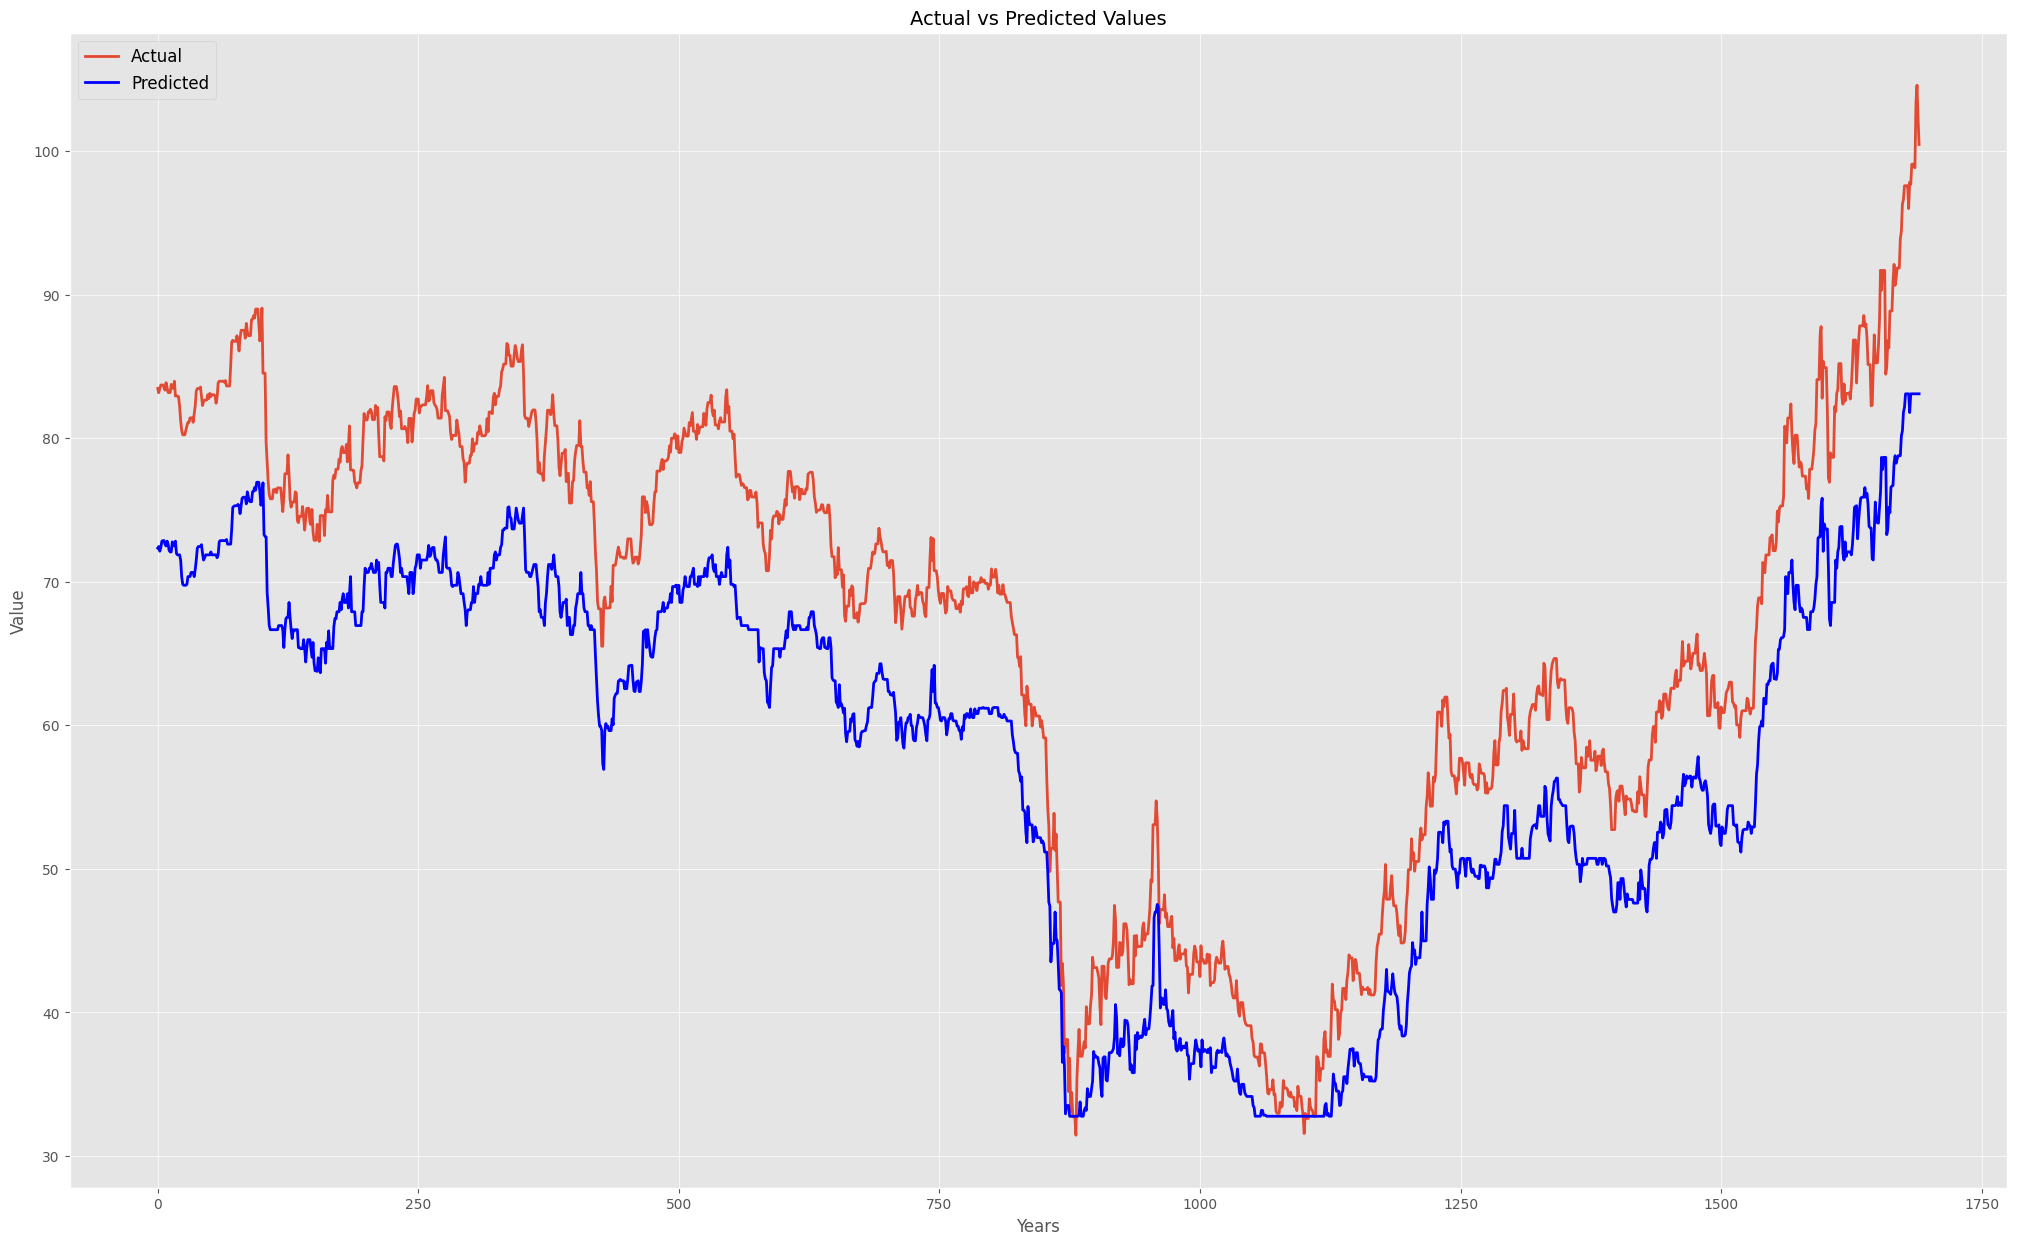

In [36]:
plt.figure(figsize=(25, 15))
plt.plot(y_test, '-', label='Actual')
plt.plot(predictions, '-', color='blue', label='Predicted')
plt.xlabel('Years', fontsize=12)
plt.ylabel('Value', fontsize=12)

plt.title('Actual vs Predicted Values', fontsize=14)
plt.legend(fontsize=12)
plt.show()

# Evaluation of the XGboost Model #
***
---

In [37]:
def evaluacion_metrica(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [38]:
evaluacion_metrica(y_test, predictions)


Evaluation metric results:-
MSE is : 80.55969914387451
MAE is : 8.590176720418992
RMSE is : 8.975505509099447
MAPE is : 12.737279457417362
R2 is : 0.6747546547213203



# Facebook Prophet model #
***
---

# Had a situation with fbprophet so only going to work with "prophet" #
***
---

In [39]:
from prophet import Prophet


### Data selection ###
***

In [40]:
mf= pd.read_csv("/Users/me/Desktop/ML_clon/src/data/oil and gas stock prices.csv")
mf = mf.loc[mf.Symbol=="XOM"]
mf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5647 entries, 0 to 5646
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      5647 non-null   object 
 1   Symbol    5647 non-null   object 
 2   Open      5647 non-null   float64
 3   High      5647 non-null   float64
 4   Low       5647 non-null   float64
 5   Close     5647 non-null   float64
 6   Volume    5647 non-null   int64  
 7   Currency  5647 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 397.1+ KB


In [41]:
mf.Date = pd.to_datetime(mf.Date)
mf = mf[["Date","Close"]].copy()
mf.rename(columns={"Date":"ds","Close":"y"},inplace=True)
mf.head()

,ds,y
0,2000-01-03,39.16
1,2000-01-04,38.41
2,2000-01-05,40.50
3,2000-01-06,42.59
4,2000-01-07,42.47


# Train & test #
***
---

In [42]:
train_data_pr = mf.iloc[:4500]
test_data_pr = mf.iloc[4500:]

In [43]:
test_data_pr.shape

(1147, 2)

In [44]:
train_data_pr.shape

(4500, 2)

In [45]:
mf.shape

(5647, 2)

# Creation & training #
***
---

In [46]:
m = Prophet()
m.fit(train_data_pr)

15:16:15 - cmdstanpy - INFO - Chain [1] start processing
15:16:20 - cmdstanpy - INFO - Chain [1] done processing


# Looking to the future #
***
---

In [47]:
future = m.make_future_dataframe(periods=12,freq='D')
prophet_pred = m.predict(future)

In [48]:
prophet_pred


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-03,39.777548,35.555802,46.314168,39.777548,39.777548,0.923521,0.923521,0.923521,0.140068,0.140068,0.140068,0.783452,0.783452,0.783452,0.0,0.0,0.0,40.701069
1,2000-01-04,39.784321,35.718097,46.125681,39.784321,39.784321,1.006593,1.006593,1.006593,0.236365,0.236365,0.236365,0.770228,0.770228,0.770228,0.0,0.0,0.0,40.790914
2,2000-01-05,39.791094,35.601545,46.129962,39.791094,39.791094,0.961731,0.961731,0.961731,0.209355,0.209355,0.209355,0.752376,0.752376,0.752376,0.0,0.0,0.0,40.752825
3,2000-01-06,39.797867,35.680123,45.817634,39.797867,39.797867,0.904746,0.904746,0.904746,0.174909,0.174909,0.174909,0.729837,0.729837,0.729837,0.0,0.0,0.0,40.702613
4,2000-01-07,39.804640,35.579060,45.446776,39.804640,39.804640,0.882202,0.882202,0.882202,0.179590,0.179590,0.179590,0.702612,0.702612,0.702612,0.0,0.0,0.0,40.686842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4507,2017-11-25,78.581866,72.855638,82.966845,78.581866,78.581866,-0.585310,-0.585310,-0.585310,-0.470144,-0.470144,-0.470144,-0.115167,-0.115167,-0.115167,0.0,0.0,0.0,77.996556
4508,2017-11-26,78.569972,73.104660,83.079437,78.569972,78.569972,-0.567905,-0.567905,-0.567905,-0.470143,-0.470143,-0.470143,-0.097761,-0.097761,-0.097761,0.0,0.0,0.0,78.002067
4509,2017-11-27,78.558078,74.034777,83.676515,78.558078,78.558078,0.061586,0.061586,0.061586,0.140068,0.140068,0.140068,-0.078483,-0.078483,-0.078483,0.0,0.0,0.0,78.619663
4510,2017-11-28,78.546183,73.753429,84.000717,78.546183,78.546183,0.178952,0.178952,0.178952,0.236365,0.236365,0.236365,-0.057412,-0.057412,-0.057412,0.0,0.0,0.0,78.725136


## Plotting the data ##
***
---

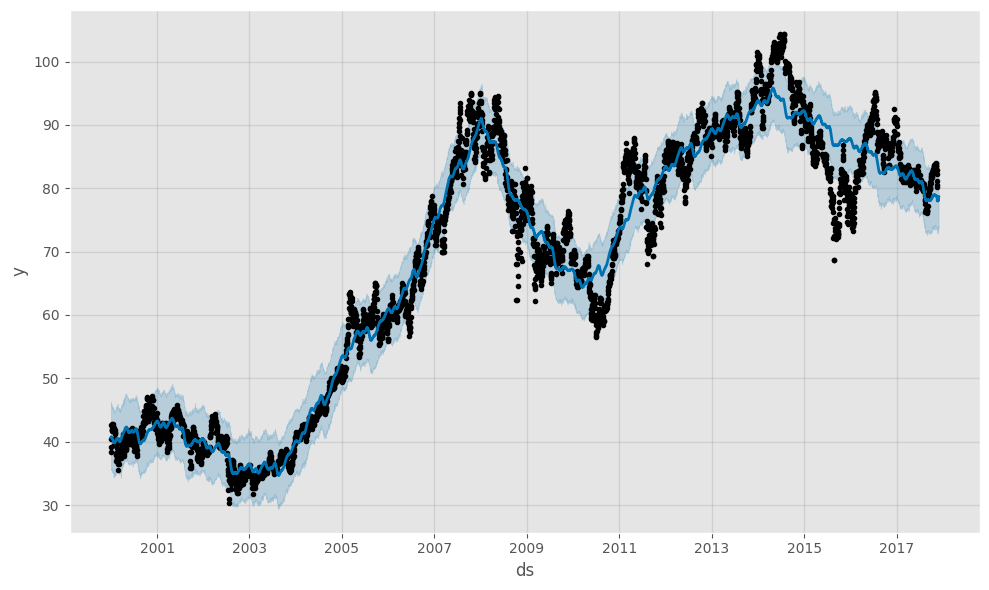

In [49]:
fig1 = m.plot(prophet_pred)


In [50]:
from sklearn.metrics import mean_squared_error, r2_score


y_pred = tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean squared error: {mse}")
print(f"R-squared: {r2}")



from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(tree, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")


Mean squared error: 2.011445213630988
R-squared: 0.9918791504937453
Cross-validation scores: [0.93311104 0.97855213 0.97057127 0.97293342 0.96190814]


In [51]:
new_data = df.iloc[5000,1:].values.reshape(1, -1)
new_pred = tree.predict(new_data)
print(f"New prediction: {new_pred}")

New prediction: [88.4]


In [52]:
import joblib
joblib.dump(tree, 'decision_tree_model.joblib')


['decision_tree_model.joblib']

In [53]:
X_test

array([[ 83.11,  83.11,  83.11,  83.24],
       [ 83.11,  83.11,  83.24,  83.47],
       [ 83.11,  83.24,  83.47,  83.17],
       ...,
       [ 99.09,  99.09,  98.84, 103.37],
       [ 99.09,  98.84, 103.37, 104.59],
       [ 98.84, 103.37, 104.59, 102.33]])

In [54]:
import joblib

model = joblib.load("decision_tree_model.joblib")

predictions = model.predict(X_test)
pr = pd.DataFrame(predictions)
print(pr)

           0
0      84.29
1      84.35
2      84.22
3      86.90
4      83.57
...      ...
1686   99.03
1687  100.13
1688  102.31
1689  102.31
1690  101.60

[1691 rows x 1 columns]
